In [1]:
import xarray as xr
import pandas as pd
import gc
from tqdm import tqdm
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import time
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader

In [2]:
def setup_globe(ax):
#     ax.set_global() 
    ax.set_extent([-180,180,-60,75],crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
#     ax.add_feature(cartopy.feature.LAND, facecolor='lightgray',zorder=0)
    ax.add_feature(cartopy.feature.LAKES, facecolor='none',edgecolor='black',
                   linewidth=0.5,zorder=5)
    
    ax.add_feature(cartopy.feature.BORDERS,
                   facecolor='none',
                   edgecolor='black',
                   linewidth=0.5,zorder=5)


def setup_colorbar_text(ax,p,title_text,xt=True,yt=True):
    ax.set_xlabel("")
    ax.set_ylabel("")
#     cbar = plt.colorbar(p, ax=ax,
#                     orientation="vertical",
#                     fraction=0.1,
#                     shrink=0.75,
#                     pad=0.02,
#                     aspect=30,
#                     extend="neither")
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False,zorder=4)
    lon_formatter = LongitudeFormatter()#zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    if xt is True:
        g.xlocator = mticker.FixedLocator([-90, 0, 90])
        ax.xaxis.set_major_formatter(lon_formatter)
    if yt is True:
        ax.yaxis.set_major_formatter(lat_formatter)
    
    ax.set_title(title_text)
    
def plot_scatter(ax,df,vmin,vmax,cmap):
    df_temp = df.copy()
    df_temp["lon_new"] = np.where(df_temp['lon'] <= 180, 
                                  df_temp['lon'], 
                                  df_temp['lon']-360)
    norm = mpl.colors.BoundaryNorm(np.arange(18),256)
    p = ax.scatter(df_temp["lon"],df_temp["lat"],c=df_temp[0],
                   s=0.5,
                   vmin=vmin,
                   vmax=vmax,
                   cmap=cmap,
                   norm=norm,
                   zorder=3,rasterized=True)
    
    return p
    
def plot_map(ax, df, xt, yt, vmin, vmax, cmap, title_text):
#     ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    setup_globe(ax)
    if xt is True:
        ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
    if yt is True:
        ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
    
#     if i==0: 
#         ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
#         ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
#     elif i==1:
#         ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
    p = plot_scatter(ax,df,vmin,vmax,cmap)
    setup_colorbar_text(ax,p,title_text,xt,yt) 

In [3]:
vari_ls = ["QBOT","UBOT","VBOT",
           "TREFHT",
           "FLNS","FSNS",
           "PRECT","PRSN"]

# path_ls = glob("/glade/scratch/zhonghua/CMIP5-RCP85_csv/*")
# model_ls = [path.split("/")[-1] for path in path_ls]
model_ls = ['ACCESS1-0', 'FGOALS-s2', 'HadGEM2-ES', 'GFDL-CM3', 'MIROC5', 
            'MIROC-ESM-CHEM', 'ACCESS1-3', 'GFDL-ESM2G', 'GFDL-ESM2M', 
            'HadGEM2-CC', 'MRI-CGCM3', 'MRI-ESM1', 'CSIRO-Mk3-6-0', 
            'MIROC-ESM', 'CanESM2', 'CNRM-CM5', 'IPSL-CM5A-MR']
save_dir = "/glade/scratch/zhonghua/feature_dist_95/"

In [4]:
def workflow(var,ax1,ax2,x1t,y1t,x2t,y2t,year,cmap="RdYlBu_r"):
    df_min = pd.read_csv(save_dir+model_ls[0]+"_"+var+"_min.csv").rename(columns={var:model_ls[0]})
    df_max = pd.read_csv(save_dir+model_ls[0]+"_"+var+"_max.csv").rename(columns={var:model_ls[0]})
    for i in range(1,len(model_ls)):
        df_min_tmp = pd.read_csv(save_dir+model_ls[i]+"_"+var+"_min.csv").rename(columns={var:model_ls[i]})
        if ((var=="PRSN") | (var=="PRECT")):
            df_min_tmp[model_ls[i]][df_min_tmp[model_ls[i]]<0]=0
        df_min = pd.merge(df_min, df_min_tmp, on=["lat","lon"],how="inner")
        df_max_tmp = pd.read_csv(save_dir+model_ls[i]+"_"+var+"_max.csv").rename(columns={var:model_ls[i]})
        df_max = pd.merge(df_max, df_max_tmp, on=["lat","lon"],how="inner")
        del df_min_tmp, df_max_tmp
        gc.collect()
    if year=="30yrs":
        df_CESM_min = pd.read_csv(save_dir+"CESM"+"_"+var+"_min.csv")
        df_CESM_max = pd.read_csv(save_dir+"CESM"+"_"+var+"_max.csv")
    elif year=="10yrs":
        df_CESM_min = pd.read_csv(save_dir+"CESM"+"_"+var+"_10yrs_min.csv")
        df_CESM_max = pd.read_csv(save_dir+"CESM"+"_"+var+"_10yrs_max.csv")
    
    min_stat = {"lat":df_min.lat,
                "lon":df_min.lon}

    max_stat = {"lat":df_max.lat,
                "lon":df_max.lon}

    for model in model_ls:
        min_stat[model]=(df_min[model]>=df_CESM_min[var])
        max_stat[model]=(df_max[model]<=df_CESM_max[var])

    min_df = pd.DataFrame(min_stat).set_index(["lat","lon"]).sum(axis=1)
    max_df = pd.DataFrame(max_stat).set_index(["lat","lon"]).sum(axis=1)

    plot_map(ax1, min_df.reset_index(), x1t, y1t,
             0, 17,
             cmap, var+" (min)")

    plot_map(ax2, max_df.reset_index(), x2t, y2t,
             0, 17,
             cmap, var+" (max)")

## 95%, 30 yrs

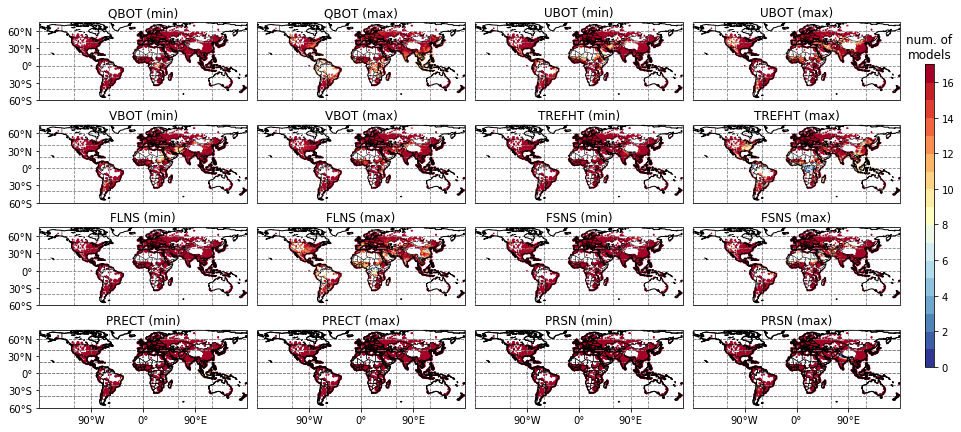

In [5]:
fig = plt.figure(figsize=(13.5,6))

for i in range(len(vari_ls)):
    var = vari_ls[i]
    ax1 = plt.subplot(4,4,i*2+1,projection=ccrs.PlateCarree())
    ax2 = plt.subplot(4,4,i*2+2,projection=ccrs.PlateCarree())
    if i%2==0:
        _ = workflow(var, ax1, ax2, x1t=False, y1t=True, x2t=False, y2t=False, year="30yrs")
    else:
        _ = workflow(var, ax1, ax2, x1t=False, y1t=False, x2t=False, y2t=False, year="30yrs")
    if i==6:
        _ = workflow(var, ax1, ax2, x1t=True, y1t=True, x2t=True, y2t=False, year="30yrs")
    if i==7:
        _ = workflow(var, ax1, ax2, x1t=True, y1t=False, x2t=True, y2t=False, year="30yrs")
plt.tight_layout()
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.955, 0.15, 0.01, 0.7])
# fig.colorbar(p, cax=cbar_ax)
# cmap = mpl.cm.RdYlBu_r
cmap = plt.get_cmap("RdYlBu_r",17)
norm = mpl.colors.Normalize(vmin=0, vmax=17)
mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                          norm=norm)
cbar_ax.set_title("num. of\nmodels")
plt.savefig("../../figures/extreme_range.pdf",dpi=122)